# Exploring The Musicnet Dataset

We first mount Google drive, and then load the raw audio form of the dataset into memory.

In [1]:
# mount drive and change directory to project folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/520 Final Project"

/content/drive/.shortcut-targets-by-id/1KHBlsdIi36o_ikonJZ-usBVzGPrZlH0V/520 Final Project


Taken directly from Kaggle, MusicNet is simply a set of .wav files with detailed pitch annotations. However, in order to train a model on this dataset, we preprocessed it by segmenting each piece into 0.3-second chunks, and then saving a version of the dataset in this form. We now load in this preprocessed form of dataset.

In [3]:
import numpy as np
with open("X_train.npy", 'rb') as f:
  X_train = np.load(f)
with open("y_train.npy", 'rb') as f:
  y_train = np.load(f)
with open("X_test.npy", 'rb') as f:
  X_test = np.load(f)
with open("y_test.npy", 'rb') as f:
  y_test = np.load(f)

The MusicNet dataset is quite large. The below code prints the size of X_train and y_train in Gigabytes.

In [4]:
import sys
print(sys.getsizeof(X_train)/1024/1024/1024) # size of X_train in gigabytes
print(sys.getsizeof(y_train)/1024/1024/1024) # size of y_train in gigabytes

4.528137318789959
0.07075225561857224


Each element of X_train is a 0.3-second clip of raw audio data. We can visualize this by plotting it, and seeing it indeed looks like your typical audio waveform.

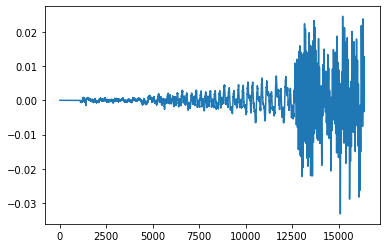

In [14]:
import matplotlib.pyplot as plt
plt.plot(X_train[0])
plt.show()

Each element in y_train is a 128-dimensional multi-hot vector representing which pitches are being played during the corresponding audio segment. The MusicNet dataset has an uneven distribution of these pitches, since not every note in the scale is equally common in classical music!

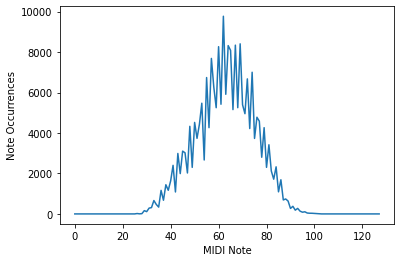

In [6]:
# plot note frequencies in training set
plt.plot(np.sum(y_train, axis=0))
plt.xlabel('MIDI Note')
plt.ylabel('Note Occurrences')
plt.show()

In addition to a dataset of raw audio clips, we also preprocessed a version of MusicNet in the spectral domain by constant-Q transforming the audio and then segmenting it into 0.3-second sections. We now load this version of the dataset.

In [15]:
with open("X_train_spec_db.npy", 'rb') as f:
  X_train = np.load(f)
with open("y_train_spec.npy", 'rb') as f:
  y_train = np.load(f)
with open("X_test_spec_db.npy", 'rb') as f:
  X_test = np.load(f)
with open("y_test_spec.npy", 'rb') as f:
  y_test = np.load(f)

In this form of the dataset, the labels look the same, but now each element of X is a 2D constant-Q transform spectrogram with time on the x-axis and frequency on the y-axis, and decibel scaling. This form of preprocessing proves extremely useful in our experiments. We now visualize such a spectrogram.

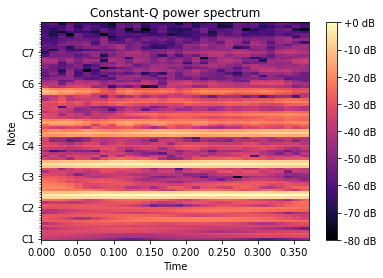

In [17]:
import librosa.display
C = X_train[1]
fs = 44100 # the sampling rate of the .wav files we are using
fig, ax = plt.subplots()
img = librosa.display.specshow(C, sr=fs, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

As you can see, lots of important frequency information is provided by the constant-Q transform!

# PCA on MusicNet

We next attempt to perform PCA on our raw audio dataset. First, we load in a subset of the raw dataset (using the full dataset will cause us to run out of RAM).

In [3]:
import numpy as np
with open("X_train.npy", 'rb') as f:
  X_train = np.load(f)[0:10000]
with open("y_train.npy", 'rb') as f:
  y_train = np.load(f)[0:10000]
with open("X_test.npy", 'rb') as f:
  X_test = np.load(f)
with open("y_test.npy", 'rb') as f:
  y_test = np.load(f)

Next, we run PCA with 128 components kept on our training data.

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 128)
pca.fit(X_train)

PCA(n_components=128)

Each of the principal components found via this method has the shape of a 0.3-second audio file. Thus, we can listen to our "eigen-audios" to try and understand what type of principal components are being picked out!

In [6]:
pca.components_.shape

(128, 16384)

We listen to the first principal component below (presaved in our Google drive).

In [7]:
from IPython.display import Audio
from IPython.display import display
wn = Audio('eigenaudios/eigenaudio1.wav', autoplay=True)
display(wn)

Since we only loaded in the first 10,000 training examples, all of the audio clips used in this PCA correspond to songs in A major from the MusicNet dataset. Thus, it is comforting that the first principal component, when played back, sounds like an A-major fifth!

Let's now listen to the second principal component:

In [8]:
from IPython.display import Audio
from IPython.display import display
wn = Audio('eigenaudios/eigenaudio2.wav', autoplay=True)
display(wn)

Now, we appear to be getting an A-major fifth, with an additional A being played an octave above the first. This is slightly less intuitive than our first principal component, but still very much sounds like a logical chord in this key!

We can continue listening to principal components in this way, getting increasingly more complicated chords. 
One might think that such a PCA decomposition into chords would be extremely useful for predicting pitch information. Unfortunately, when we tried to run semi-supervised learning (even with more than 128 principal components), it didn't work, likely due to the fact that the higher principal components do not represent pitch information quite as well as the first couple.

# PCA on constant-Q transformed MusicNet

Now, we instead run PCA on our constant-Q transform spectrograms instead of the raw audio data. We first load this dataset into memory (since this transformed dataset is smaller, we can perform PCA on it all at once).

In [3]:
import numpy as np
with open("X_train_spec_db.npy", 'rb') as f:
  X_train = np.load(f)
with open("y_train_spec.npy", 'rb') as f:
  y_train = np.load(f)
with open("X_test_spec_db.npy", 'rb') as f:
  X_test = np.load(f)
with open("y_test_spec.npy", 'rb') as f:
  y_test = np.load(f)

We flatten the dataset into a set of 1D vectors, then run PCA on it.

In [4]:
X_train_flattened = np.reshape(X_train, (X_train.shape[0],-1))
X_test_flattened = np.reshape(X_test, (X_test.shape[0], -1))

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 128)
pca.fit(X_train_flattened)

PCA(n_components=128)

We can once again visualize the principal components of this PCA (the "eigen-CQTs"), but admittedly they are a bit less interpretable than for the time-domain data... The first principal component looks like:

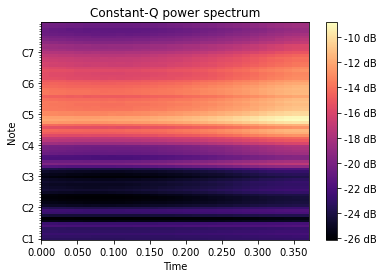

In [6]:
# visualize eigenspectrums
import matplotlib.pyplot as plt
import librosa.display
C = 1000*np.reshape(pca.components_[0], (84, 32)) # since components normalized no clear scale...
fig, ax = plt.subplots()
img = librosa.display.specshow(C, sr=44100, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

While the second principal component looks like:

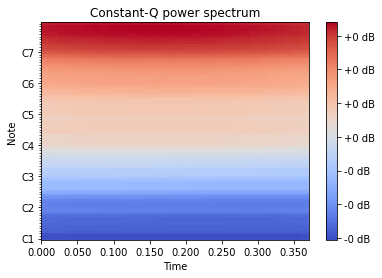

In [7]:
C = np.reshape(pca.components_[1], (84, 32))
fig, ax = plt.subplots()
img = librosa.display.specshow(C, sr=44100, x_axis='time', y_axis='cqt_note', ax=ax)
ax.set_title('Constant-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

And so on... However, semi-supervised learning works much better on this form of PCA. We now train a logistic regression on the transformed dataset to predict the presence of pitches within the range of MIDI notes 40 to 85.

In [10]:
X_pca = pca.transform(X_train_flattened)
y_train_trunc = y_train[:,40:85]

We choose max_iter=500 in our LogisticRegression classifier as otherwise the logistic regression will not converge in time. However, this makes the code take quite a while to run. Otherwise, there is no interesting hyperparameter tuning in this model past our choice of number of principal components, which we choose relatively small so as to prevent PCA from running out of RAM (at 128). However, even with this small number of principal components, we see strong performance from the logistic regression.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
clf = MultiOutputClassifier(LogisticRegression(max_iter=500)).fit(X_pca, y_train_trunc)

# Training Set Evaluation

First, we evaluate our model on the training set, computing and printing the accuracies, precisions, and recalls for each individual pitch.

In [12]:
y_pred_trunc = clf.predict(X_pca)

In [13]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
precisions = []
recalls = []
accuracies = []
for i in range(len(y_pred_trunc[0])):
  recalls += [recall_score(y_train_trunc[:,i], y_pred_trunc[:,i])]
  precisions += [precision_score(y_train_trunc[:,i], y_pred_trunc[:,i], zero_division=0)]
  accuracies += [accuracy_score(y_train_trunc[:,i], y_pred_trunc[:,i])]
print(recalls)
print(precisions)
print(accuracies)

[0.45571374574776363, 0.4566444847751563, 0.4365818985942189, 0.4815530229862855, 0.47754010695187166, 0.44873501997336884, 0.4704273058884836, 0.3807328318369328, 0.36703896748572845, 0.377705149721756, 0.4096028452874926, 0.41282290083819423, 0.3863020329138432, 0.4177637130801688, 0.38625881714595767, 0.38515713033679727, 0.35639412997903563, 0.41895553845639155, 0.4317525773195876, 0.39705942247383214, 0.43603488742719715, 0.4076215141284743, 0.4100121493262646, 0.41212954153011244, 0.38123288543590395, 0.38493697934408966, 0.37303548943711234, 0.3904761904761905, 0.3713900248745731, 0.3957522697795071, 0.4226239499258771, 0.40307678705627514, 0.38058428218252727, 0.35889894000776956, 0.38583678511736064, 0.326569060178706, 0.3189910282305416, 0.32879586510414, 0.3185100098457499, 0.33446099469830853, 0.24131455399061033, 0.31130411181978557, 0.29816180288711186, 0.2243783406925401, 0.3045971425794538]
[0.7360602360602361, 0.706772784019975, 0.7060025542784163, 0.7172724657140117, 

Next, we plot the ROC curve for middle C on our training set.

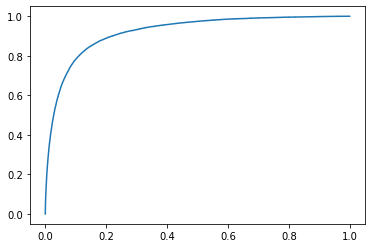

In [ ]:
# ROC curve for C4: MIDI 60, so index 20
import librosa
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
y_scores = clf.predict_proba(X_pca)
y_scores = np.array(y_scores)
fpr, tpr, thresholds = roc_curve(y_train_trunc[:,20], y_scores[20,:,1])
plt.plot(fpr, tpr)
plt.show()

And compute the area under this curve...

In [ ]:
from sklearn.metrics import auc
print(auc(fpr, tpr))

0.9208734601818787


Finally, we get the average AUC for all the pitches we are considering.

In [ ]:
# get the average AUC over all the notes
aucs = []
for i in range(45):
  fpr, tpr, _ = roc_curve(y_train_trunc[:,i], y_scores[i,:,1])
  aucs += [auc(fpr,tpr)]
print(np.mean(aucs))

0.9259178351504933


# Test Set Evaluation

We now do the same for the test set.

In [ ]:
X_test_pca = pca.transform(X_test_flattened)
y_test_trunc = y_test[:, 40:85]

In [ ]:
y_test_pred = clf.predict(X_test_pca)

In [ ]:
precisions = []
recalls = []
accuracies = []
for i in range(len(y_test_pred[0])):
  recalls += [recall_score(y_test_trunc[:,i], y_test_pred[:,i])]
  precisions += [precision_score(y_test_trunc[:,i], y_test_pred[:,i], zero_division=0)]
  accuracies += [accuracy_score(y_test_trunc[:,i], y_test_pred[:,i])]
print(recalls)
print(precisions)
print(accuracies)

[0.4444444444444444, 0.208955223880597, 0.35294117647058826, 0.6, 0.391304347826087, 0.5170068027210885, 0.24861878453038674, 0.4368932038834951, 0.2752808988764045, 0.3333333333333333, 0.5777777777777777, 0.37898089171974525, 0.25862068965517243, 0.32867132867132864, 0.3695652173913043, 0.3863080684596577, 0.32682926829268294, 0.3526570048309179, 0.3556085918854415, 0.6103896103896104, 0.4063745019920319, 0.2571428571428571, 0.4783950617283951, 0.4738219895287958, 0.17894736842105263, 0.3756906077348066, 0.425531914893617, 0.41919191919191917, 0.24686192468619247, 0.34572490706319703, 0.5129151291512916, 0.3446601941747573, 0.470873786407767, 0.385, 0.46458923512747874, 0.4909090909090909, 0.29411764705882354, 0.2914285714285714, 0.35251798561151076, 0.326271186440678, 0.4, 0.27710843373493976, 0.3698630136986301, 0.265625, 0.5]
[0.9230769230769231, 0.875, 1.0, 0.8426966292134831, 0.8289473684210527, 0.8837209302325582, 0.6617647058823529, 0.7894736842105263, 0.8448275862068966, 0.904

This time, we also print the mean recall and accuracy, so that we can report this in our paper!

In [ ]:
print(np.mean(recalls))
print(np.mean(precisions))

0.38017219980369926
0.7149124492683417


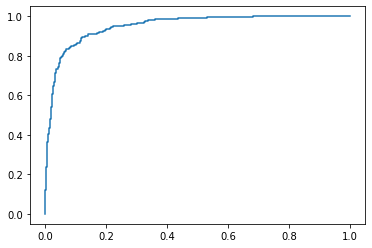

In [ ]:
y_test_scores = clf.predict_proba(X_test_pca)
y_test_scores = np.array(y_test_scores)
fpr, tpr, thresholds = roc_curve(y_test_trunc[:,20], y_test_scores[20,:,1])
plt.plot(fpr, tpr)
plt.show()

In [ ]:
import pickle
with open('pca_fpr.npy', 'wb') as f:
  np.save(f, fpr, allow_pickle=True)
with open('pca_tpr.npy', 'wb') as f:
  np.save(f, tpr, allow_pickle=True)

In [ ]:
print(auc(fpr, tpr))

0.9511647778857759


In [ ]:
# get the average AUC over all the notes
aucs = []
for i in range(45):
  fpr, tpr, _ = roc_curve(y_test_trunc[:,i], y_test_scores[i,:,1])
  aucs += [auc(fpr,tpr)]
print(np.mean(aucs))

0.9364459373285499


The performance of our model on the test set is actually slightly better than on the training set! This suggests we are probably not overfitting the data... (which would be pretty unlikely anyway given our very low model complexity).